Viking GCMS instrument data exploration and parsing
Casey Handmer
February 2019

In [23]:
import numpy as np
from matplotlib import pyplot as plt

Why start with the uncompressed files? They are nearly twice as big!

Uncompressed files typically retain structure, while good compression algorithms (of which there are hundreds) remove structure. Without knowing how compression was done, an uncompressed file is, I think, the best place to start.

In [5]:
with open("./Digital-files-raw-from-NSSDCA/5289 (VL-1)/DR005289_F00001.PHYS","rb") as f:
    rawdata = f.read()

Let's take a quick look at the data. This command outputs a string of hex symbols, which is a common way to represent binary data. Each hex symbol represents 4 bits, each pair a single byte. Most modern computers represent numbers with 64 bits (8 bytes) for double precision floats and ints.

In [284]:
rawdata[:20]

b'd\x00\x01\x00\x00X\x04\xaa/\x18\x1b\x00\x025\x0b\x01\x02\x04\x00v'

Of course we don't know how the data was encoded, but ints are a good place to start. Here are the first 500 bytes as unsigned short ints (0-255). Importantly, note that the data is periodic.

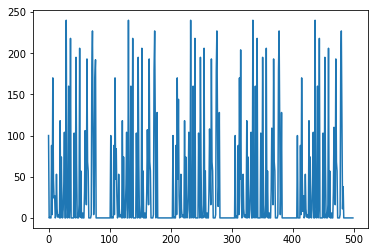

In [22]:
plt.plot([rawdata[i] for i in range(500)])

By inspection, the data has a periodicity of around 100 bytes. My assumption is, therefore, that the data from the Viking GCMS is encoded in a sequence of data "frames", each of which has a header and a body containing data.

To determine the period, I'm going to examine stream correlation with different periods. One could also perform a Fourier transform or just guess a few times and check. 

I'm also going to perform all subsequent analysis in pure binary, because one of the instrument papers mentioned a 9-bit encoding, and there's no guarantee that the data frame will line up with the edge of the chosen byte!

There should be a better way of doing this, but I'm blanking on it.

In [60]:
rawbin=np.array([[(rawdata[j]%2**(8-i))//2**(7-i) for i in range(8)] for j in range(len(rawdata))]).reshape(8*len(rawdata))

In [285]:
rawbin[:100]

array([0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0,
       1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

Compute the mean of the variance of slices of a range of lengths through the data. The underlying period will jump out at us.

In [88]:
variancearray1=[np.mean(np.var(rawbin[:a*100].reshape((100,a)),axis=0)) for a in range(1,1000)]

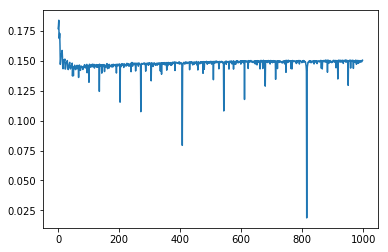

In [90]:
plt.plot(variancearray1)

In [93]:
np.where(variancearray1==np.min(variancearray1))[0][0]

815

In [73]:
period1 = 816

Of course, there is some freedom in deciding where packets begin and end, since it's possible that the raw data file might have "cut off" the beginning of the first frame. So it is useful to look at the data and see where it varies.

This graph shows above the horizontal axis the parts of the frame where the data varies. Below the axis is the underlying binary data. Some of this is changing, some isn't. The stuff that isn't might be sample headers, date, spacecraft ID, and other stuff that, while interesting, is of secondary importance at this point. 

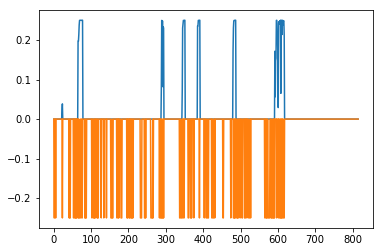

In [78]:
plt.plot(np.var(rawbin[:period1*100].reshape((100,period1)),axis=0))
plt.plot(-0.25*rawbin[:period1])

We can inspect the data graphically to interpret what the changing parts might be. For the most part, the changing parts appear to be counters. Some are counting by the frame, others every 16 frames, and the one at bits 56-80 are counting more rapidly. It turns out this is a clock counting in milliseconds. 

Two other salient features come to our attention. 

The first is the packet data after bit 592, which extends through the rest of the frame after the 250th frame. 

The second is that at the 279th frame, the data structure disappears.

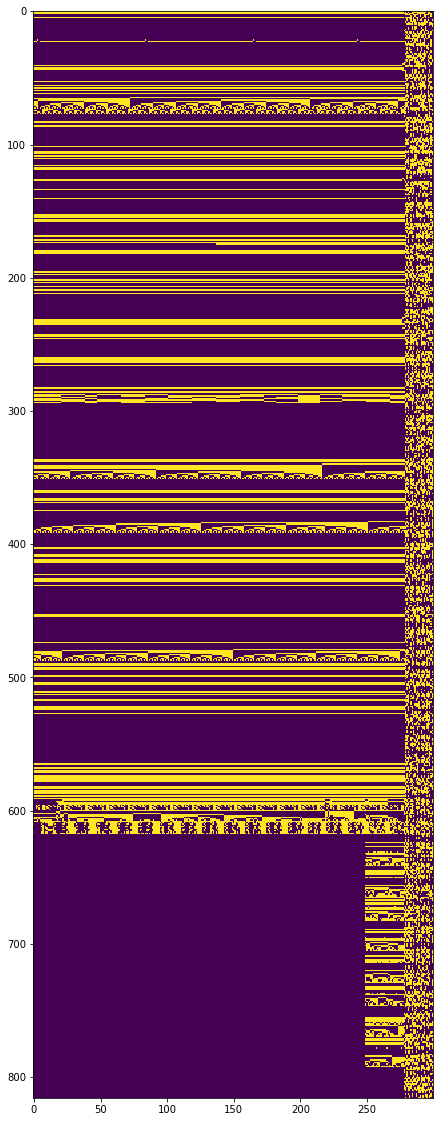

In [107]:
plt.figure(figsize=(10,20))
plt.imshow(np.transpose(rawbin[:period1*300].reshape((300,period1))))

Fortunately, periodicity re-emerges on a longer scale.

In [91]:
variancearray2=[np.mean(np.var(rawbin[300*period1:300*period1+a*100].reshape((100,a)),axis=0)) for a in range(1,5000)]

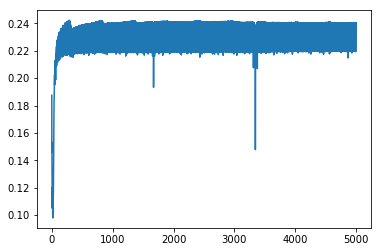

In [92]:
plt.plot(variancearray2)

In [95]:
np.where(variancearray2==np.min(variancearray2[2000:]))[0][0]

3343

In [96]:
period2=3344

Comparing the variance and the underlying data, as before, we see a very similar header structure followed by a much longer body of data. My instinct is that this is where the instrument data will be.

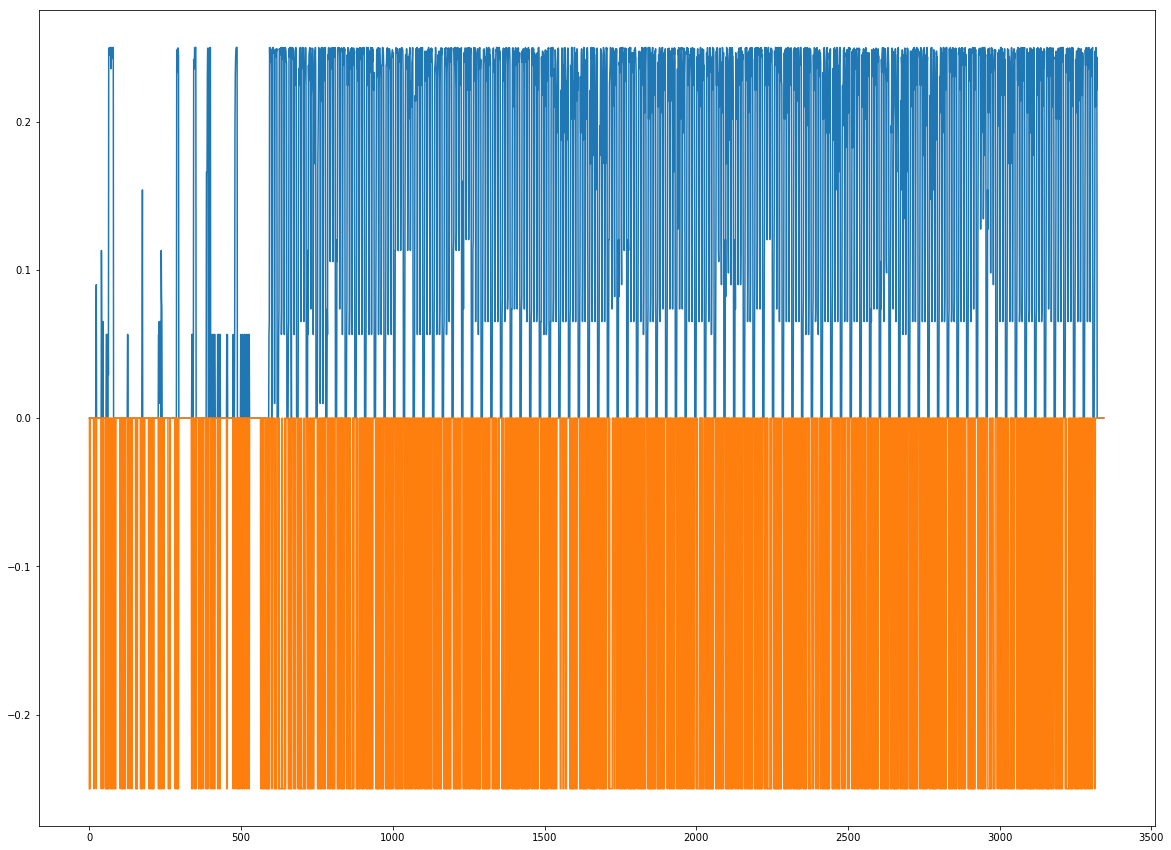

In [99]:
plt.figure(figsize=(20,15))
plt.plot(np.var(rawbin[278*period1:278*period1+period2*100].reshape((100,period2)),axis=0))
plt.plot(-0.25*rawbin[278*period1:278*period1+period2])

This plot shows that the headers for the two different length data frames lines up. By convention, this is the alignment I will use for the beginning of the data frame, though it could be a bit either way.

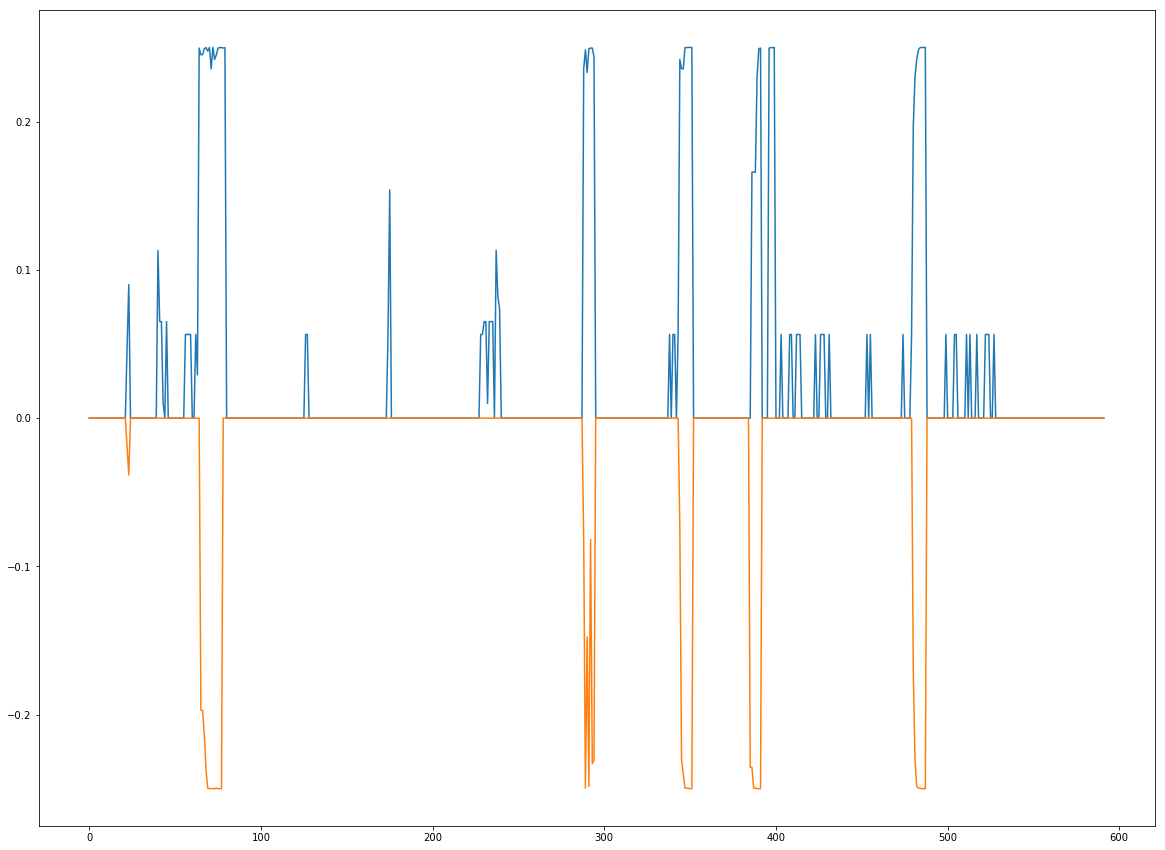

In [101]:
plt.figure(figsize=(20,15))
plt.plot(np.var(rawbin[278*period1:278*period1+period2*100].reshape((100,period2)),axis=0)[:74*8])
plt.plot(-np.var(rawbin[:period1*100].reshape((100,period1)),axis=0)[:74*8])


These frames are rather large to display graphically, but I'll do it anyway, then show some sections of interest at closer scale.

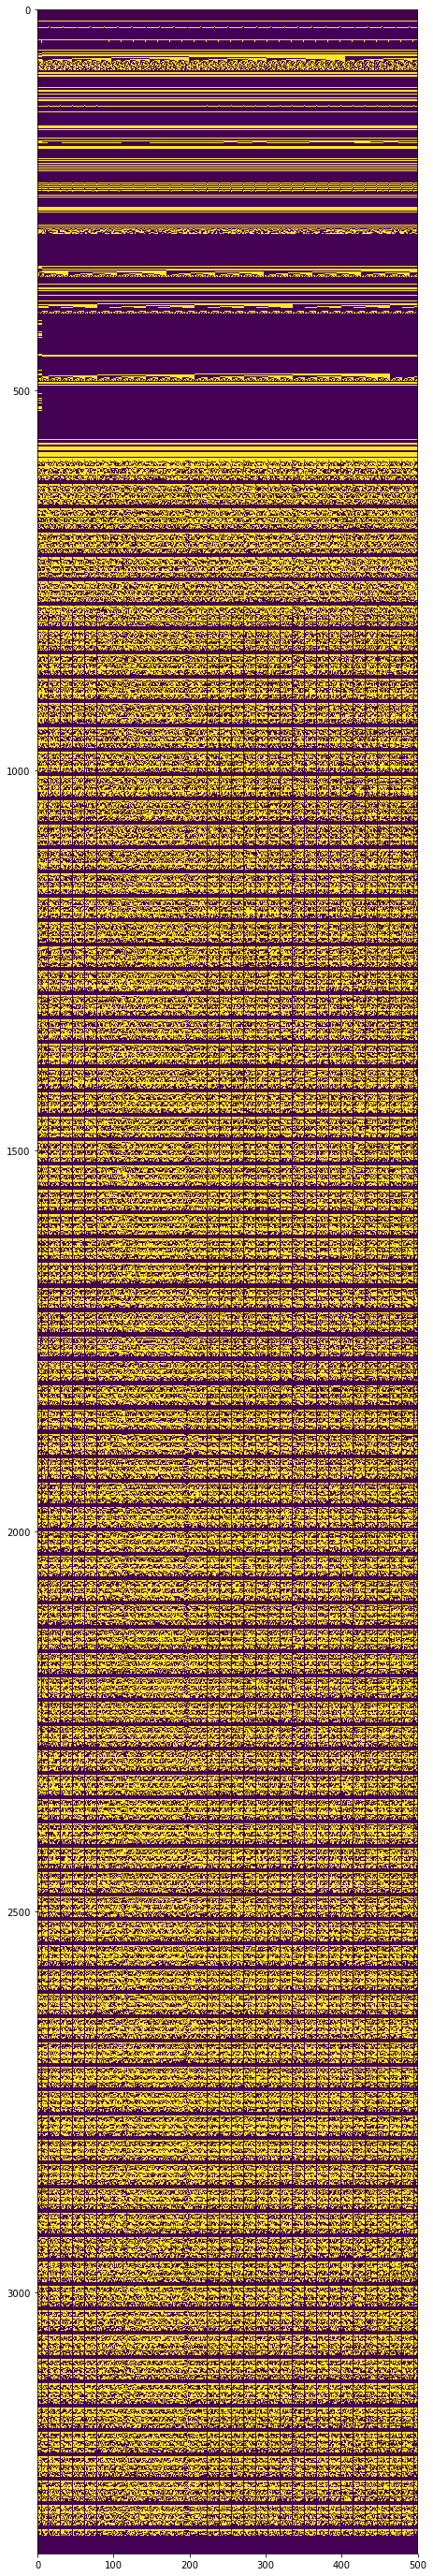

In [112]:
plt.figure(figsize=(20,50))
plt.imshow(np.transpose(rawbin[278*period1:278*period1+period2*500].reshape((500,period2))))

This is the header section

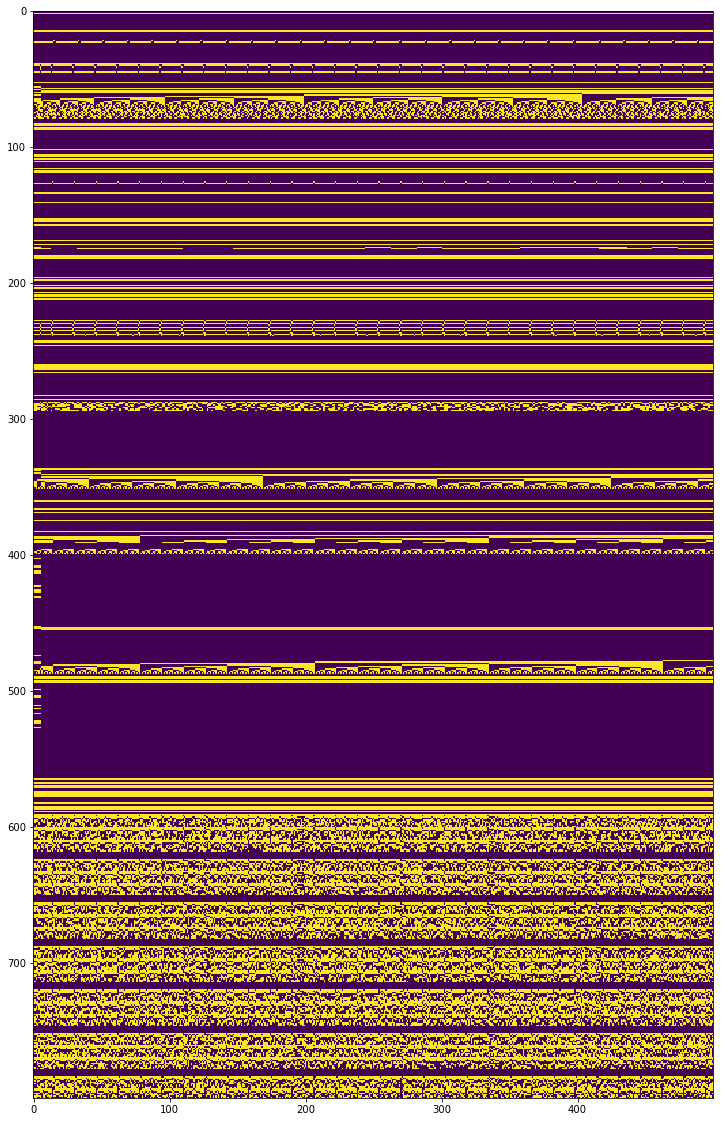

In [114]:
plt.figure(figsize=(20,20))
plt.imshow(np.transpose(rawbin[278*period1:278*period1+period2*500].reshape((500,period2)))[:800])

Above, the transition from header to body within the frames is clear. The data is stored as 9 bit ints within 32 bit (4 byte) repeating units. In total, there are 256 channels per frame. Every 16th frame is nearly empty, and (as we will see) contains frame-specific engineering data. In total there are 15x256 = 3840 channels in a complete scan.

The plot below shows 200 frames' worth of data for just 6 channels, demonstrating both the 16 frame periodicity and 9 bit integer character of the data.

A quick note on nomenclature. A sample is composed of around 500 scans, each scan is composed of 16 data frames. Each frame has a header (74 bytes) and a body (344 bytes). The body is a sequence of 86 4-byte units, each of which contains 3 9-bit integer measurements. The measurements turn out to be the log of the mass spectrometer current.

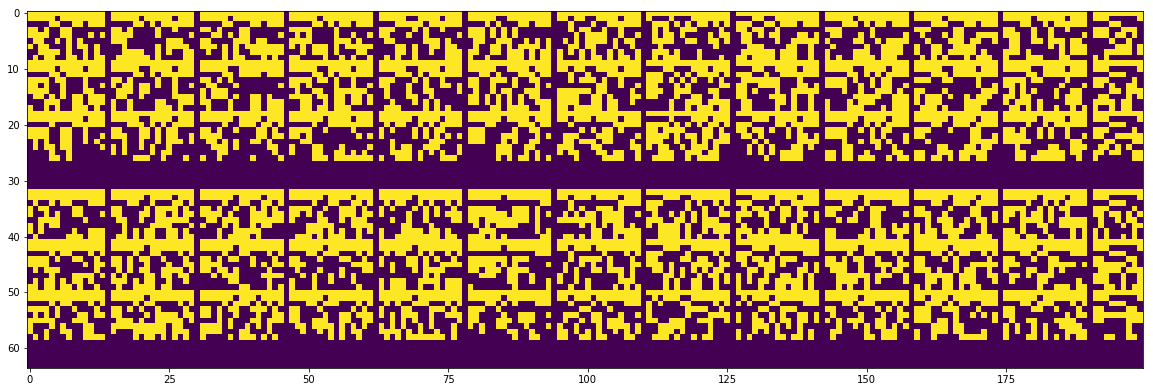

In [145]:
plt.figure(figsize=(20,20))
plt.imshow(np.transpose(rawbin[278*period1:278*period1+period2*200].reshape((200,period2)))[8*74+32*10:8*74+32*12])

Let's take a closer look at the timer, which lives on bytes 8-10.

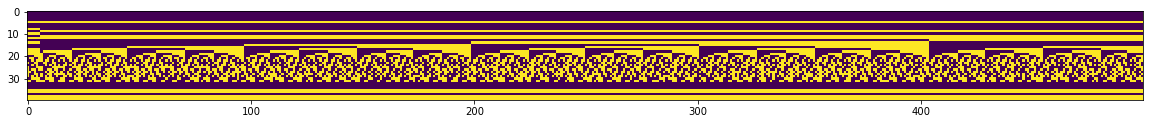

In [120]:
plt.figure(figsize=(20,20))
plt.imshow(np.transpose(rawbin[278*period1:278*period1+period2*500].reshape((500,period2)))[48:88])

Most of the raw data is probably 3344 bit dataframes, so there are probably around 8300 data frames. 

In [152]:
rawbin.shape[0]/3344

8319.440191387559

In [155]:
frametimestamps=np.array([np.dot(rawbin[278*period1+56+period2*i:278*period1+80+period2*i],np.flip([2**i for i in range(24)],axis=0)) for i in range(8200)])

There's something funny going on in the first scan, where the time is reset.

In [142]:
frametimestamps[:50]

array([11170173, 11170833, 11171494, 11172154, 11172815, 11173475,
        5774957,  5775617,  5776278,  5776938,  5777599,  5778259,
        5778920,  5779580,  5780169,  5780571,  5781231,  5781892,
        5782552,  5783213,  5783873,  5784534,  5785194,  5785855,
        5786515,  5787176,  5787836,  5788497,  5789157,  5789818,
        5790407,  5790809,  5791469,  5792130,  5792790,  5793451,
        5794111,  5794772,  5795432,  5796092,  5796753,  5797413,
        5798074,  5798734,  5799395,  5800055,  5800644,  5801046,
        5801707,  5802367])

The time stamps deltas alternate between 660 and 661, but every 16 frames reduces to 402, corresponding to the frame with almost no data.

In [141]:
np.diff(frametimestamps)[15:47]

array([660, 661, 660, 661, 660, 661, 660, 661, 660, 661, 660, 661, 660,
       661, 589, 402, 660, 661, 660, 661, 660, 661, 660, 660, 661, 660,
       661, 660, 661, 660, 589, 402])

The total of 16 sequential time stamp deltas is the accumulated time per stamp, 10238. Documentation indicates that each scan takes 10.24s, so I think it's a fair guess that the time stamps are measured in milliseconds. 

In [149]:
np.sum(np.diff(frametimestamps)[15:31])

10238

Let's plot the entire time series. What we see here is that after about 3000 data frames, the phase of the frames changes, probably due to a lag somewhere in the data. To process the complete dataset, we'll need to find the indices of the beginnings of all the data frames.

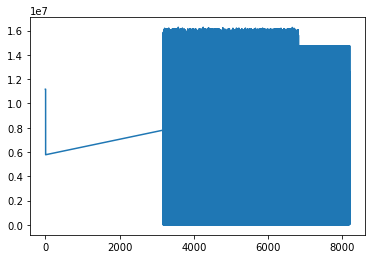

In [156]:
plt.plot(frametimestamps)

There probably is a better way to do this, but not one I can think of right now.

In [166]:
def arrayPatternMatch(array,pattern):
    candidate = (array==pattern[0])
    for i in range(1,len(pattern)):
        if pattern[i]!=-1: # This will function as a wildcard, since we're only performing matching on 0 and 1
            candidate *= (np.roll(array,-i)==pattern[i])
    return np.where(candidate)[0]

We'll take a closer look at the start of each frame.

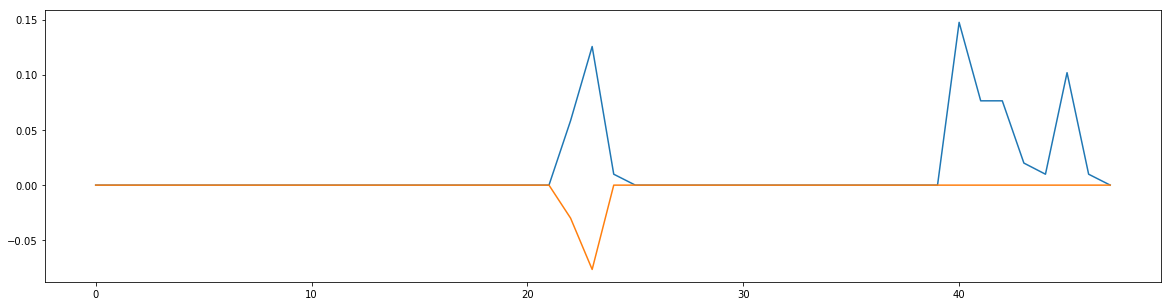

In [215]:
plt.figure(figsize=(20,5))
plt.plot(np.var(rawbin[278*period1:278*period1+period2*100].reshape((100,period2)),axis=0)[:48])
plt.plot(-np.var(rawbin[:period1*100].reshape((100,period1)),axis=0)[:48])

It needs rather a long match string to avoid false positives and negatives. Getting these right took some trial and error but in the end worked out.

In [351]:
matchpattern1=rawbin[:48].copy()
matchpattern1[22]=-1
matchpattern1[23]=-1

In [352]:
matchpattern2=rawbin[278*period1:278*period1+50].copy()
matchpattern2[22]=-1
matchpattern2[23]=-1
matchpattern2[40]=-1
matchpattern2[41]=-1
matchpattern2[42]=-1
matchpattern2[43]=-1
matchpattern2[44]=-1
matchpattern2[45]=-1

In [355]:
matchpattern2

array([ 1,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,
        0,  0,  0,  0,  0, -1, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  1, -1, -1, -1, -1, -1, -1,  0,  0,  0,  0])

In [185]:
frameindex1=arrayPatternMatch(rawbin,matchpattern1)

In [207]:
frameindex2=arrayPatternMatch(rawbin,matchpattern2)

In [258]:
np.nonzero(np.bincount(np.diff(frameindex2)))

(array([3344, 3616]),)

Now we can dial up any frame we want!

In [287]:
def getFrameHeader(index):
    return rawbin[frameindex2[index]:frameindex2[index]+8*74]

def getFrameData(index):
    return np.array([[np.dot(rawbin[frameindex2[index]+8*(74+4*i)+9*j:frameindex2[index]+8*(74+4*i)+9*(j+1)],np.flip([2**k for k in range(9)],axis=0)) for j in range(3)] for i in range(86)]).reshape(3*86)[:-2]

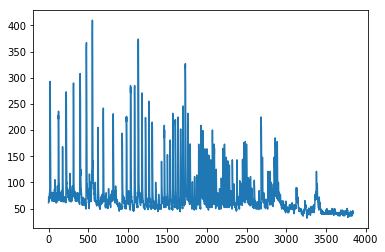

In [256]:
plt.plot(512-np.array([getFrameData(i) for i in range(15,30,1)]).reshape(15*256))

The 1st scan has a missing frame and a corrupted frame.

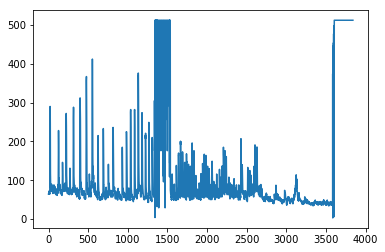

In [306]:
plt.plot(512-np.array([getFrameData(i) for i in range(0,15,1)]).reshape(15*256))

The 197th scan has some data anomaly with three missing frames. Any parsing function will need to take that into account.

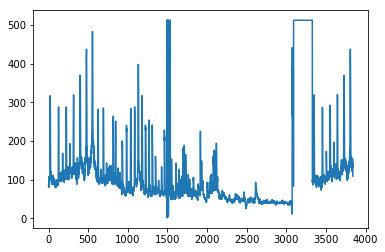

In [267]:
plt.plot(512-np.array([getFrameData(i) for i in range(3167,3167+15,1)]).reshape(15*256))

The 425th scan also has a similar anomaly.

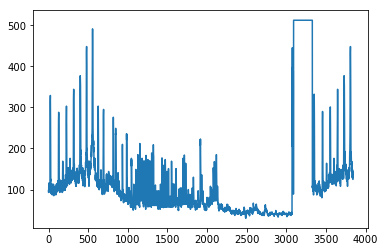

In [270]:
plt.plot(512-np.array([getFrameData(i) for i in range(6812,6812+15,1)]).reshape(15*256))

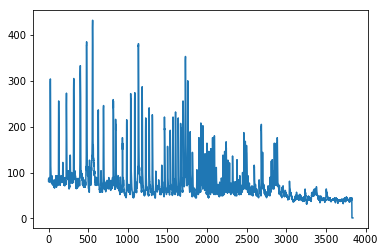

In [275]:
plt.plot(512-np.array([getFrameData(i) for i in range(8233,8248,1)]).reshape(15*256))

Let's check the frame counters to see if there is a way to detect a reset scan without having to crunch data directly. It turns out the 49th byte counts 0-15 over and over, with 0 denoting the engineering data frame. This enables us to put the frame data in the right place, as shown below.

In [365]:
scanstart = np.where(np.array([np.dot(getFrameHeader(j)[49*8:50*8],np.flip([2**i for i in range(8)],axis=0)) for j in range(0,len(frameindex2))])==1)[0]

In [367]:
def getFrameDataErrorTolerant(scanindex):
    index=scanstart[scanindex]
    output=np.zeros(3840)
    indices=np.array([np.dot(getFrameHeader(j)[49*8:50*8],np.flip([2**i for i in range(8)],axis=0)) for j in range(index,index+15)])-1
    for i in range(15):
        output[indices[i]*256:(indices[i]+1)*256] = getFrameData(index+i)
        if indices[i]==14:
            break
    return output

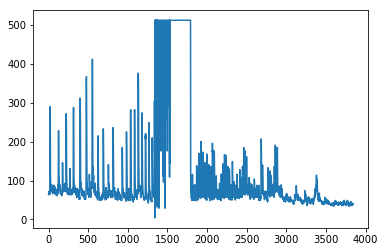

In [368]:
plt.plot(512-getFrameDataErrorTolerant(0))

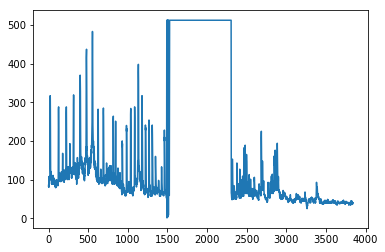

In [371]:
plt.plot(512-getFrameDataErrorTolerant(198))

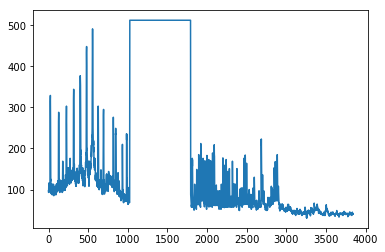

In [373]:
plt.plot(512-getFrameDataErrorTolerant(426))

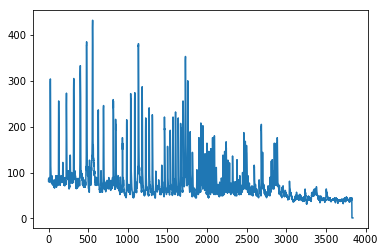

In [375]:
plt.plot(512-getFrameDataErrorTolerant(515))

In [377]:
alldata=np.array([getFrameDataErrorTolerant(i) for i in range(516)])

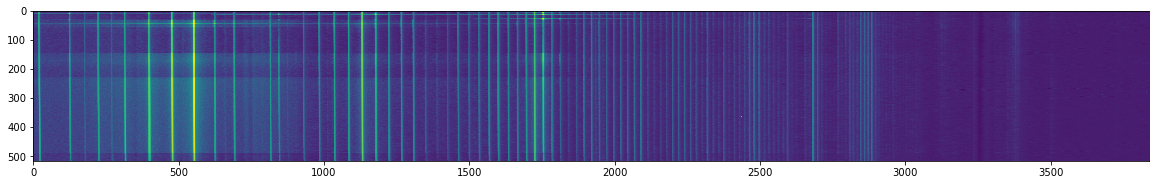

In [378]:
plt.figure(figsize=(20,10))
plt.imshow(512-alldata)

In [379]:
np.savetxt("./recoveredcsvs/DR005289_F0000"+str(1)+".csv",alldata,delimiter=',')


Calibration
Header data

The data, for some reason, seems to be encoded upside down. That is to say, subtracting it from 512 gives a sensible looking graph.

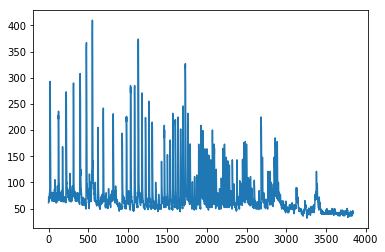

In [381]:
plt.plot(512-alldata[1])

According to the papers, the mass spectrometer performs exponential reductions in voltage from about 2300V to about 125V in 3840 steps, spanning masses from 12 to 215 AMU. In a mass spectrometer, the voltage is inversely proportional to mass, so in the graph above, mass is increasing from left to right.

In [423]:
vstep=(219/11.8)**(1/3839)

def MassToIndex(mass):
    return np.log(mass/11.8)/np.log(vstep)
    
def IndexToMass(index):
    return 11.8*vstep**index

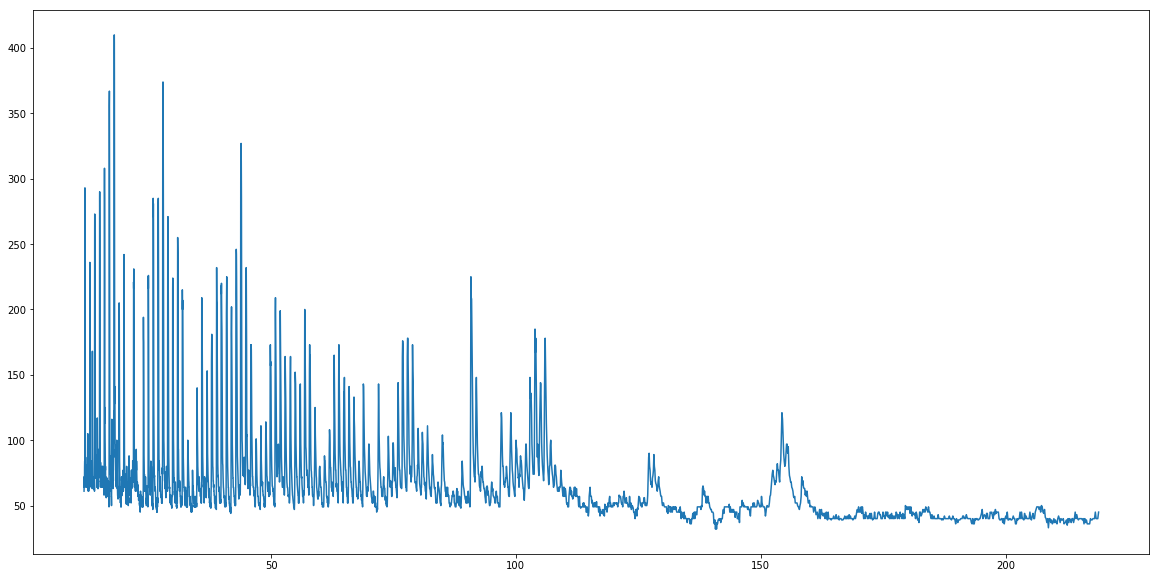

In [427]:
plt.figure(figsize=(20,10))
plt.plot([IndexToMass(i) for i in range(3840)],512-alldata[1])

To make this look like the microfilms, we need to take an appropriate exponential.

In [436]:
mask=np.concatenate((np.zeros(int(np.round(MassToIndex(47)))),1+np.zeros(3840-int(np.round(MassToIndex(47))))))

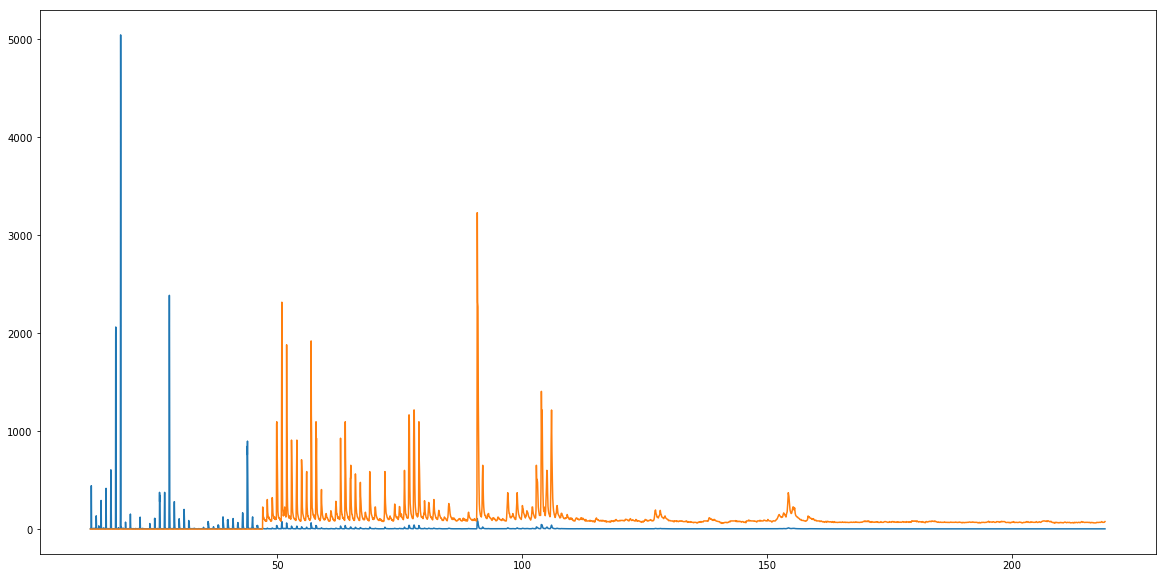

In [440]:
plt.figure(figsize=(20,10))
plt.plot([IndexToMass(i) for i in range(3840)],2**(0.03*(512-alldata[1])))
plt.plot([IndexToMass(i) for i in range(3840)],30*mask*2**(0.03*(512-alldata[1])))

As expected, the dominant peaks are found at M = 18, 28, and 44. (H2O, CO, CO2).

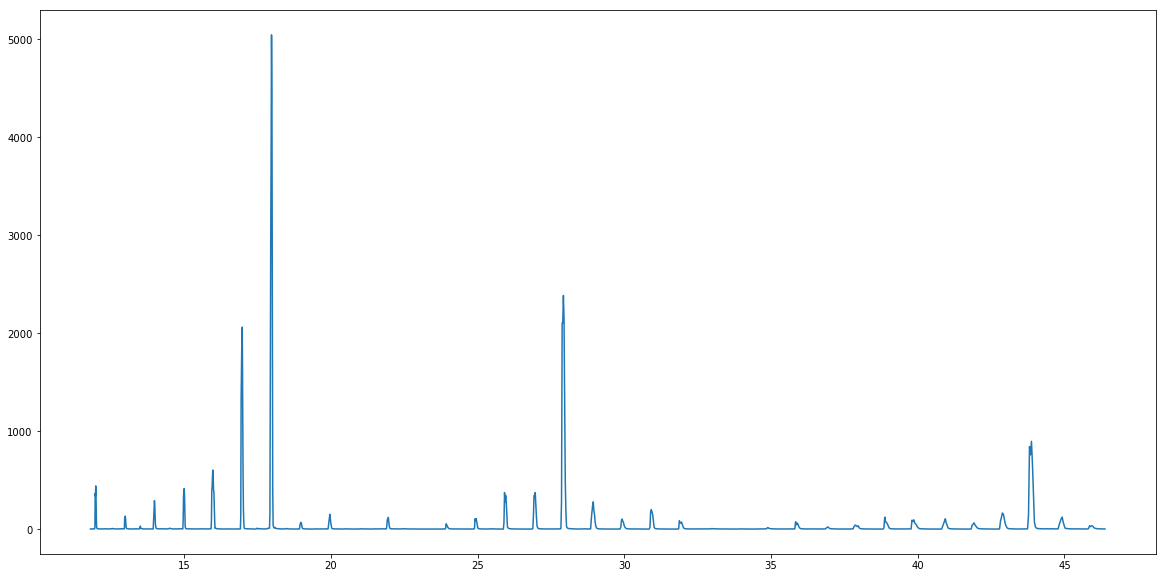

In [441]:
plt.figure(figsize=(20,10))
plt.plot([IndexToMass(i) for i in range(1800)],2**(0.03*(512-alldata[1][:1800])))